# Exploratoy Analysis

This notebook contains the exploratory analysis of the zonaprop's apartments on rent data.

We will see how is the data, what are the features, and how we can use them to predict the price of an apartment.

In [5]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load the data

In [6]:
# Load necessary libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Load the data
data_path = r"C:\Users\Galker\zona-prop-scraper\data\departamentos-venta-q-dueno-vende-2025-02-25-12-20-19.csv"
df = pd.read_csv(data_path)

# Display the first few rows of the dataframe
df.head()

# Display information about the dataframe
df.info()

# Drop non-castable to float price values
df = df[df.price_value.apply(lambda x: re.match(r'\d+\.?\d+', str(x)) is not None)]

# Convert price_value column to float
df['price_value'] = df.price_value.astype(float)

# Print the number of rows in the dataframe
print(f'Rows quantity: {len(df)}')

# Clean NaN data in some columns
df.isna().sum()

# Drop unnecessary columns
df.drop(columns=['POSTING_CARD_GALLERY'], inplace=True)
df.dropna(subset=['square_meters_area_0', 'square_meters_area_1'], inplace=True)
df.drop(columns=['ha'], inplace=True)

# Create columns with max and min area using the two columns with area values
df.loc[:, 'covered_area'] = df[['square_meters_area_0', 'square_meters_area_1']].min(axis=1)
df.loc[:, 'total_area'] = df[['square_meters_area_0', 'square_meters_area_1']].max(axis=1)

# Data Analysis
# Distribution of the area of the apartments
def get_df_column_by_quantile(df, column, quantile):
    return df[df[column] < df[column].quantile(quantile)][column]

df_data = df[(df.covered_area < df.covered_area.quantile(.99)) & (df.total_area < df.total_area.quantile(.99))]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(df_data.covered_area, bins=40)
axs[0].set_title('Covered area')

axs[1].hist(df_data.total_area, bins=40)
axs[1].set_title('Total area')

plt.show()

plt.figure(figsize=(10, 10))
plt.scatter(df_data.covered_area, df_data.total_area, alpha=0.7, s=20)

max_total_area = df_data.total_area.max()

plt.plot([0, max_total_area], [0, max_total_area], color='red')
plt.title('Covered area vs Total area')
plt.show()

# Distribution of the price of the apartment in function of the area
price_types = df.price_type.unique()
print(f'Price types: {price_types}')

df_pesos = df[df['price_type'] == '$']

df_pesos_data = df_pesos[
    (df_pesos.covered_area < df_pesos.covered_area.quantile(.99))
    & (df_pesos.total_area < df_pesos.total_area.quantile(.99))
]

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(df_pesos_data['covered_area'], df_pesos_data['price_value'], alpha=0.7, s=10)
ax.set_title('Covered area vs price value')

ax.set_xlabel('Covered area')
ax.set_ylabel('Price value')

plt.show()

# Distribution of the price of the apartment in function of the rooms
plt.figure(figsize=(10, 10))
plt.hist(df_pesos_data['price_value'], bins=20)
plt.title('Price value distribution')
plt.xlabel('Price value')
plt.show()

df_data = df_pesos_data[df_pesos_data['rooms_0'] < 30]

fig, axs = plt.subplots(6, 1, figsize=(20, 60))

rest_of_room_quantity_df = df_data[df_data['rooms_0'] > 5]

for i in range(1, 6):
    room_quantity_df = df_data[df_data['rooms_0'] == i]
    axs[i-1].hist(room_quantity_df['price_value'], bins=30, range=(0, 500000))
    axs[i-1].set_title(f'Price value distribution for {i} room quantity')
    axs[i-1].axvline(room_quantity_df['price_value'].mean(), color='red')

axs[5].hist(rest_of_room_quantity_df['price_value'], bins=30, range=(0, 500000))
axs[5].set_title(f'Price value distribution for more than 5 room quantity')
axs[5].axvline(rest_of_room_quantity_df['price_value'].mean(), color='red')

plt.show()

# Correlation analysis
columns_to_analize = ['price_value', 'covered_area', 'total_area', 'rooms_0', 'bathrooms_0', 'bedrooms_0', 'parking_0']
columns_renames = {
    'price_value': 'price',
    'covered_area': 'covered area',
    'total_area': 'total area',
    'rooms_0': 'rooms',
    'bathrooms_0': 'bathrooms',
    'bedrooms_0': 'bedrooms',
    'parking_0': 'parking'
}

corr = df_pesos_data[columns_to_analize].rename(columns=columns_renames).corr()

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr, vmin=-1, vmax=1)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        c = corr.iloc[j,i]
        ax.text(i, j, str(round(c, 2)), va='center', ha='center')

plt.title('Correlation matrix')
plt.show()

# Location analysis
locations = df_pesos_data.location.unique()
print('Some Locations')
for location in locations[:10]:
    print(f'    - {location}')

df_pesos_data.loc[:, 'neighborhood'] = df_pesos_data.location.apply(lambda x: x.split(',')[0])
df_pesos_data.loc[:, 'city'] = df_pesos_data.location.apply(lambda x: x.split(',')[1])

neighborhoods = df_pesos_data.neighborhood.unique()
print('Some Neighborhoods')
for neighborhood in neighborhoods[:10]:
    print(f'    - {neighborhood}')

cities_quantity = df_pesos_data.city.value_counts()
cities_quantity = cities_quantity[cities_quantity > 100]

fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(cities_quantity.index, cities_quantity.values, color='lightblue')
ax.barh(cities_quantity[cities_quantity > 120].index, cities_quantity[cities_quantity > 120].values, color='blue')
ax.barh(cities_quantity[cities_quantity > 200].index, cities_quantity[cities_quantity > 200].values, color='darkblue')
ax.barh(cities_quantity[cities_quantity > 500].index, cities_quantity[cities_quantity > 500].values, color='red')

plt.title('Quantity of estates per city')
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   url                     268 non-null    object 
 1   POSTING_CARD_GALLERY    268 non-null    object 
 2   price_value             268 non-null    int64  
 3   price_type              268 non-null    object 
 4   expenses_value          188 non-null    object 
 5   expenses_type           187 non-null    object 
 6   location                268 non-null    object 
 7   POSTING_CARD_FEATURES   268 non-null    object 
 8   description             268 non-null    object 
 9   CARD_FAV                0 non-null      float64
 10  CARD_VIEWPHONE          0 non-null      float64
 11  CARD_WHATSAPP           154 non-null    object 
 12  CARD_CONTACT_MODAL      268 non-null    object 
 13  address                 268 non-null    object 
 14  square_meters_area      267 non-null    fl

KeyError: ['square_meters_area_0', 'square_meters_area_1']

In [ ]:
df = pd.read_csv(data_path)

In [ ]:
df.head()

,url,POSTING_CARD_GALLERY,price_value,price_type,expenses_value,expenses_type
0,/propiedades/clasificado/alclapin-alquiler-2-a...,32,950,USD,300000,$
1,/propiedades/clasificado/veclapin-apto-credito...,14,74000,USD,92000,$
2,/propiedades/clasificado/veclapin-venta-2-ambi...,21,149000,USD,NaN,NaN
3,/propiedades/clasificado/veclapin-apto-credito...,18,74500,USD,40000,$
4,/propiedades/clasificado/veclapin-venta-pentho...,18,229900,USD,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   url                   164 non-null    object
 1   POSTING_CARD_GALLERY  164 non-null    int64 
 2   price_value           164 non-null    object
 3   price_type            156 non-null    object
 4   expenses_value        84 non-null     object
 5   expenses_type         83 non-null     object
dtypes: int64(1), object(5)
memory usage: 7.8+ KB


We see that the price_value column is of type object, so we need to convert it to float.

In [ ]:
# Drop no casteable to float price values
import re
df = df[df.price_value.apply(lambda x: re.match(r'\d+\.?\d+', str(x)) is not None)]

In [ ]:
df['price_value'] = df.price_value.astype(float)

In [ ]:
print(f'Rows quantity: {len(df)}')

Rows quantity: 156


We have to clean nan data of some columns.

In [ ]:
df.isna().sum()

url                      0
POSTING_CARD_GALLERY     0
price_value              0
price_type               0
expenses_value          72
expenses_type           73
dtype: int64

In [ ]:
df.drop(columns=['POSTING_CARD_GALLERY'], inplace=True)

In [ ]:
df.dropna(subset=['square_meters_area_0', 'square_meters_area_1'], inplace=True)

KeyError: ['square_meters_area_0', 'square_meters_area_1']

Clean "ha" useless column.

In [ ]:
df.drop(columns=['ha'], inplace=True)

KeyError: "['ha'] not found in axis"

There are two columns asociated to the area of the apartment, these correspond to the total area and the covered area.

We have to use the minimun value between the two columns to set the covered area and the maximum value to set the total area.

In [ ]:
# Create columns with max and min area using the two columns with area values
df.loc[:, 'covered_area'] = df[['square_meters_area_0', 'square_meters_area_1']].min(axis=1)
df.loc[:, 'total_area'] = df[['square_meters_area_0', 'square_meters_area_1']].max(axis=1)

KeyError: "None of [Index(['square_meters_area_0', 'square_meters_area_1'], dtype='object')] are in the [columns]"

# Data Analysis

Let's see the distribution of the area of the apartments.

In [ ]:
def get_df_column_by_quantile(df, column, quantile):
    return df[df[column] < df[column].quantile(quantile)][column]

In [ ]:
from matplotlib import pyplot as plt

df_data = df[(df.covered_area < df.covered_area.quantile(.99)) & (df.total_area < df.total_area.quantile(.99))]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(df_data.covered_area, bins=40)
axs[0].set_title('Covered area')

axs[1].hist(df_data.total_area, bins=40)
axs[1].set_title('Total area')

plt.show()

AttributeError: 'DataFrame' object has no attribute 'covered_area'

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(df_data.covered_area, df_data.total_area, alpha=0.7, s=20)

max_total_area = df_data.total_area.max()

plt.plot([0, max_total_area], [0, max_total_area], color='red')
plt.title('Covered area vs Total area')
plt.show()

NameError: name 'df_data' is not defined

<Figure size 1000x1000 with 0 Axes>

Now we can see the distribution of the price of the apartment in function of the area.

We will analyze only the apartments with price_type = $. (The price is in argentinian pesos)

In [ ]:
price_types = df.price_type.unique()

print(f'Price types: {price_types}')

Price types: ['USD' '$']


In [ ]:
df_pesos = df[df['price_type'] == '$']

df_pesos_data = df_pesos[
    (df_pesos.covered_area < df_pesos.covered_area.quantile(.99))
    & (df_pesos.total_area < df_pesos.total_area.quantile(.99))
]

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(df_pesos_data['covered_area'], df_pesos_data['price_value'], alpha=0.7, s=10)
ax.set_title('Covered area vs price value')

ax.set_xlabel('Covered area')
ax.set_ylabel('Price value')

plt.show()


AttributeError: 'DataFrame' object has no attribute 'covered_area'

We can see that the price of the apartment increases with the area.

Let's see the distribution of the price of the apartment in function of the rooms.

First at all, let's see the distribution of the price_value.

In [ ]:
plt.figure(figsize=(10, 10))
plt.hist(df_pesos_data['price_value'], bins=20)
plt.title('Price value distribution')
plt.xlabel('Price value')
plt.show()

NameError: name 'df_pesos_data' is not defined

<Figure size 1000x1000 with 0 Axes>

And now let's see the distribution of the price of the apartment in function of the rooms.

In [ ]:
df_data = df_pesos_data[df_pesos_data['rooms_0'] < 30]


fig, axs = plt.subplots(6, 1, figsize=(20, 60))

rest_of_room_quantity_df = df_data[df_data['rooms_0'] > 5]

for i in range(1, 6):

    room_quantity_df = df_data[df_data['rooms_0'] == i]

    axs[i-1].hist(room_quantity_df['price_value'], bins=30, range=(0, 500000))
    axs[i-1].set_title(f'Price value distribution for {i} room quantity')
    axs[i-1].axvline(room_quantity_df['price_value'].mean(), color='red')

axs[5].hist(rest_of_room_quantity_df['price_value'], bins=30, range=(0, 500000))
axs[5].set_title(f'Price value distribution for more than 5 room quantity')
axs[5].axvline(rest_of_room_quantity_df['price_value'].mean(), color='red')

plt.show()


NameError: name 'df_pesos_data' is not defined

We can see that the price value mean increases with the number of rooms until 4 rooms, and then it doesn't increase anymore and it even decreases.

Let´s continue with the correlation analysis.

There are some columns that are not useful for the analysis, so we will not use them.

We will use the columns defined below.

In [ ]:
columns_to_analize = ['price_value', 'covered_area', 'total_area', 'rooms_0', 'bathrooms_0', 'bedrooms_0', 'parking_0']

In [ ]:
columns_renames = {
    'price_value': 'price',
    'covered_area': 'covered area',
    'total_area': 'total area',
    'rooms_0': 'rooms',
    'bathrooms_0': 'bathrooms',
    'bedrooms_0': 'bedrooms',
    'parking_0': 'parking'
}

In [ ]:
corr = df_pesos_data[columns_to_analize].rename(columns=columns_renames).corr()

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr, vmin=-1, vmax=1)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        c = corr.iloc[j,i]
        ax.text(i, j, str(round(c, 2)), va='center', ha='center')

plt.title('Correlation matrix')

plt.show()

NameError: name 'df_pesos_data' is not defined

We could see that the price is highly correlated with the area and rooms but are less correlated with the parking.

The rooms and bedrooms are highly correlated, and it makes sense because the bedrooms are a subset of the rooms.

# Location

Let's see the distribution of the price of the apartment in function of the location.

In [ ]:
locations = df_pesos_data.location.unique()

NameError: name 'df_pesos_data' is not defined

In [ ]:
print('Some Locations')
for location in locations[:10]:
    print(f'    - {location}')

Some Locations
    - Centro / Microcentro, Capital Federal
    - Caballito, Capital Federal
    - Miraflores (Funes Hill), Zona 13
    - Alto Alberdi, Córdoba
    - Lomas de Zamora, GBA Sur
    - Núñez, Capital Federal
    - Flores, Capital Federal
    - La Plata, La Plata
    - Palermo, Capital Federal
    - Centro, Córdoba


There are two levels of location, the first one could be interpreted as the neighborhood and the second one as the city.

In [ ]:
df_pesos_data.loc[:, 'neighborhood'] = df_pesos_data.location.apply(lambda x: x.split(',')[0])
df_pesos_data.loc[:, 'city'] = df_pesos_data.location.apply(lambda x: x.split(',')[1])

In [ ]:
neighborhoods = df_pesos_data.neighborhood.unique()

print('Some Neighborhoods')
for neighborhood in neighborhoods[:10]:
    print(f'    - {neighborhood}')

Some Neighborhoods
    - Centro / Microcentro
    - Caballito
    - Miraflores (Funes Hill)
    - Alto Alberdi
    - Lomas de Zamora
    - Núñez
    - Flores
    - La Plata
    - Palermo
    - Centro


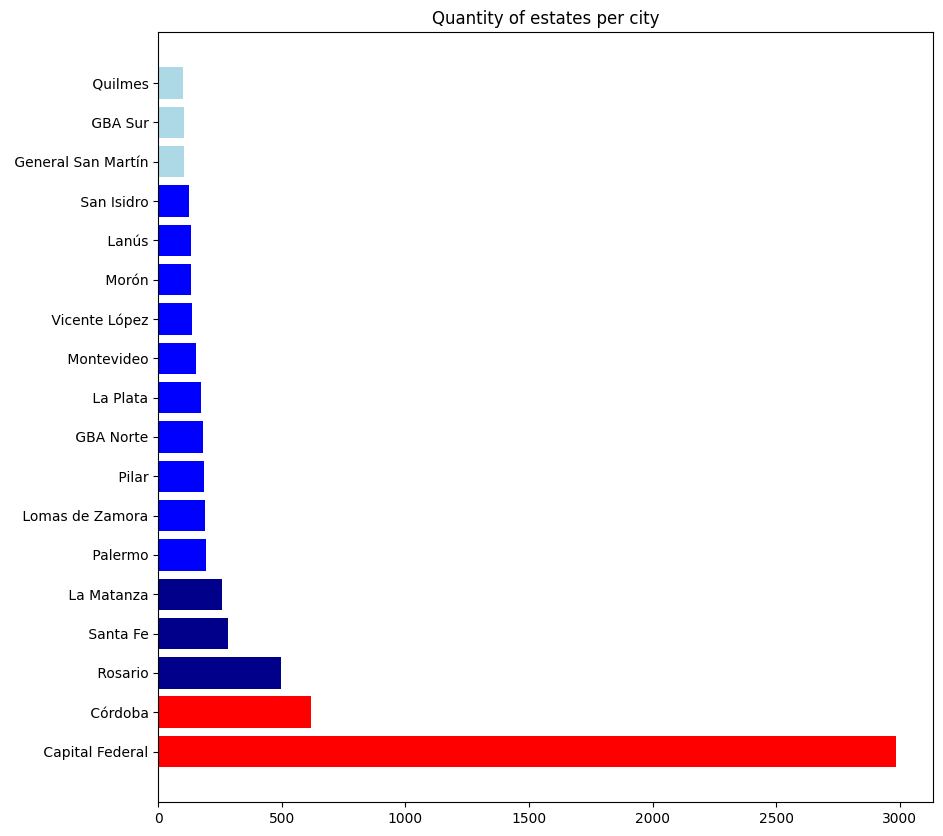

In [ ]:
cities_quantity = df_pesos_data.city.value_counts()

cities_quantity = cities_quantity[cities_quantity > 100]


fig, ax = plt.subplots(figsize=(10, 10))


ax.barh(cities_quantity.index, cities_quantity.values, color='lightblue')

ax.barh(cities_quantity[cities_quantity > 120].index, cities_quantity[cities_quantity > 120].values, color='blue')

ax.barh(cities_quantity[cities_quantity > 200].index, cities_quantity[cities_quantity > 200].values, color='darkblue')

ax.barh(cities_quantity[cities_quantity > 500].index, cities_quantity[cities_quantity > 500].values, color='red')


plt.title('Quantity of estates per city')

plt.show()

There are many aparments in CABA and Córdoba.

Buenos Aires is subdivided in zones so that Capital Federal is more reprented than we can see in the plot.

We can see that zones like Palermo, Vicente López and San Isidro are zones that belong to the Capital Federal so there are more apartments in these zones.

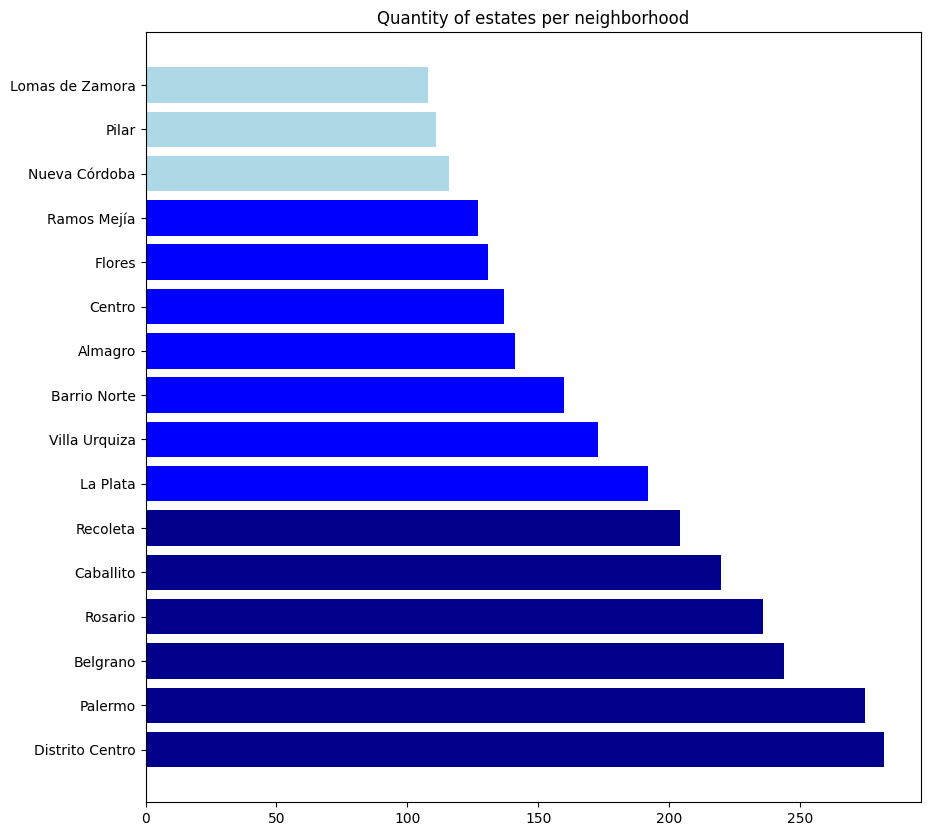

In [ ]:
neighborhoods_quantity = df_pesos_data.neighborhood.value_counts()

neighborhoods_quantity[:10]

neighborhoods_quantity = neighborhoods_quantity[neighborhoods_quantity > 100]

fig, ax = plt.subplots(figsize=(10, 10))


ax.barh(neighborhoods_quantity.index, neighborhoods_quantity.values, color='lightblue')

ax.barh(neighborhoods_quantity[neighborhoods_quantity > 120].index, neighborhoods_quantity[neighborhoods_quantity > 120].values, color='blue')

ax.barh(neighborhoods_quantity[neighborhoods_quantity > 200].index, neighborhoods_quantity[neighborhoods_quantity > 200].values, color='darkblue')

ax.barh(neighborhoods_quantity[neighborhoods_quantity > 500].index, neighborhoods_quantity[neighborhoods_quantity > 500].values, color='red')


plt.title('Quantity of estates per neighborhood')

plt.show()



There are 5 neighborhoods that belong to the Capital Federal in the top 5.

# Analysis by zone

Let's see the distribution of the price of the apartment in function of the zone.

We will analyze the apartments in the top 10 neighboorhoods with more apartments.

In [ ]:
neigborhoods_to_analize = neighborhoods_quantity[:10].index

In [ ]:
df_analize = df_pesos_data[df_pesos_data.neighborhood.isin(neigborhoods_to_analize)]

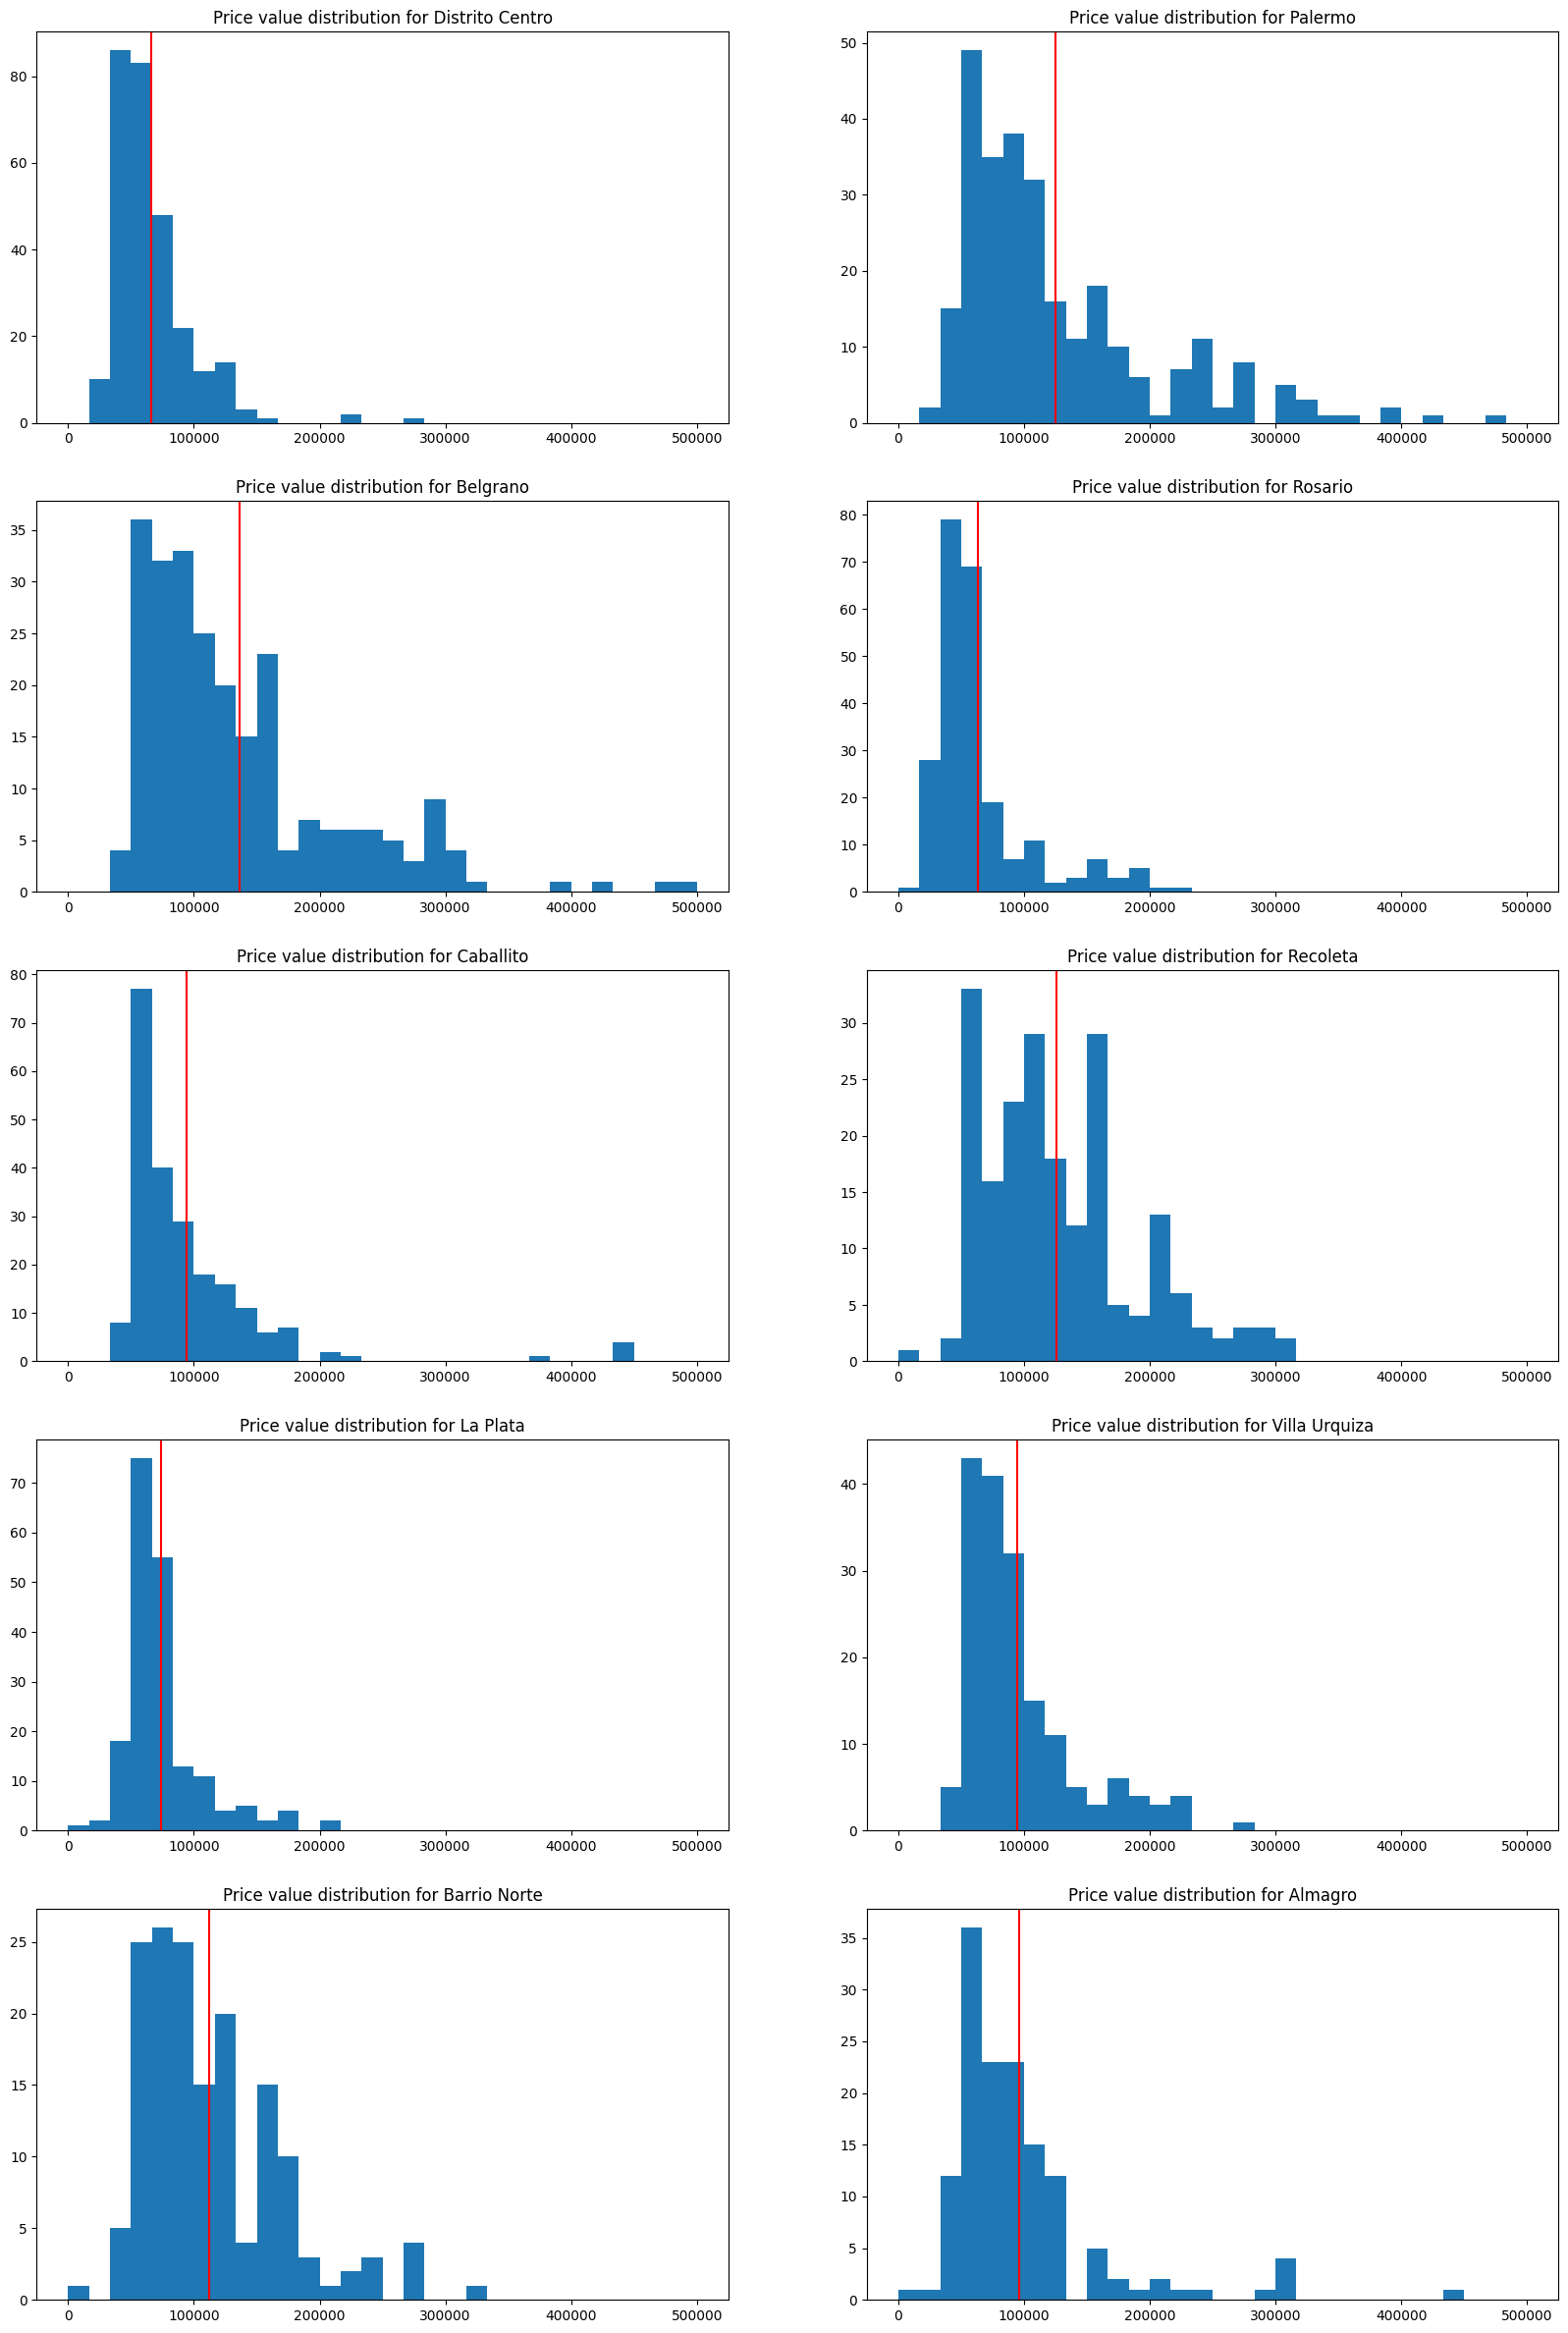

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(20, 30))

for i, neighborhood in enumerate(neigborhoods_to_analize):

    df_neighborhood = df_analize[df_analize.neighborhood == neighborhood]

    axs[i//2, i%2].hist(df_neighborhood['price_value'], bins=30, range=(0, 500000))
    axs[i//2, i%2].set_title(f'Price value distribution for {neighborhood}')
    axs[i//2, i%2].axvline(df_neighborhood['price_value'].mean(), color='red')


plt.show()

NameError: name 'neigborhoods_to_analize' is not defined

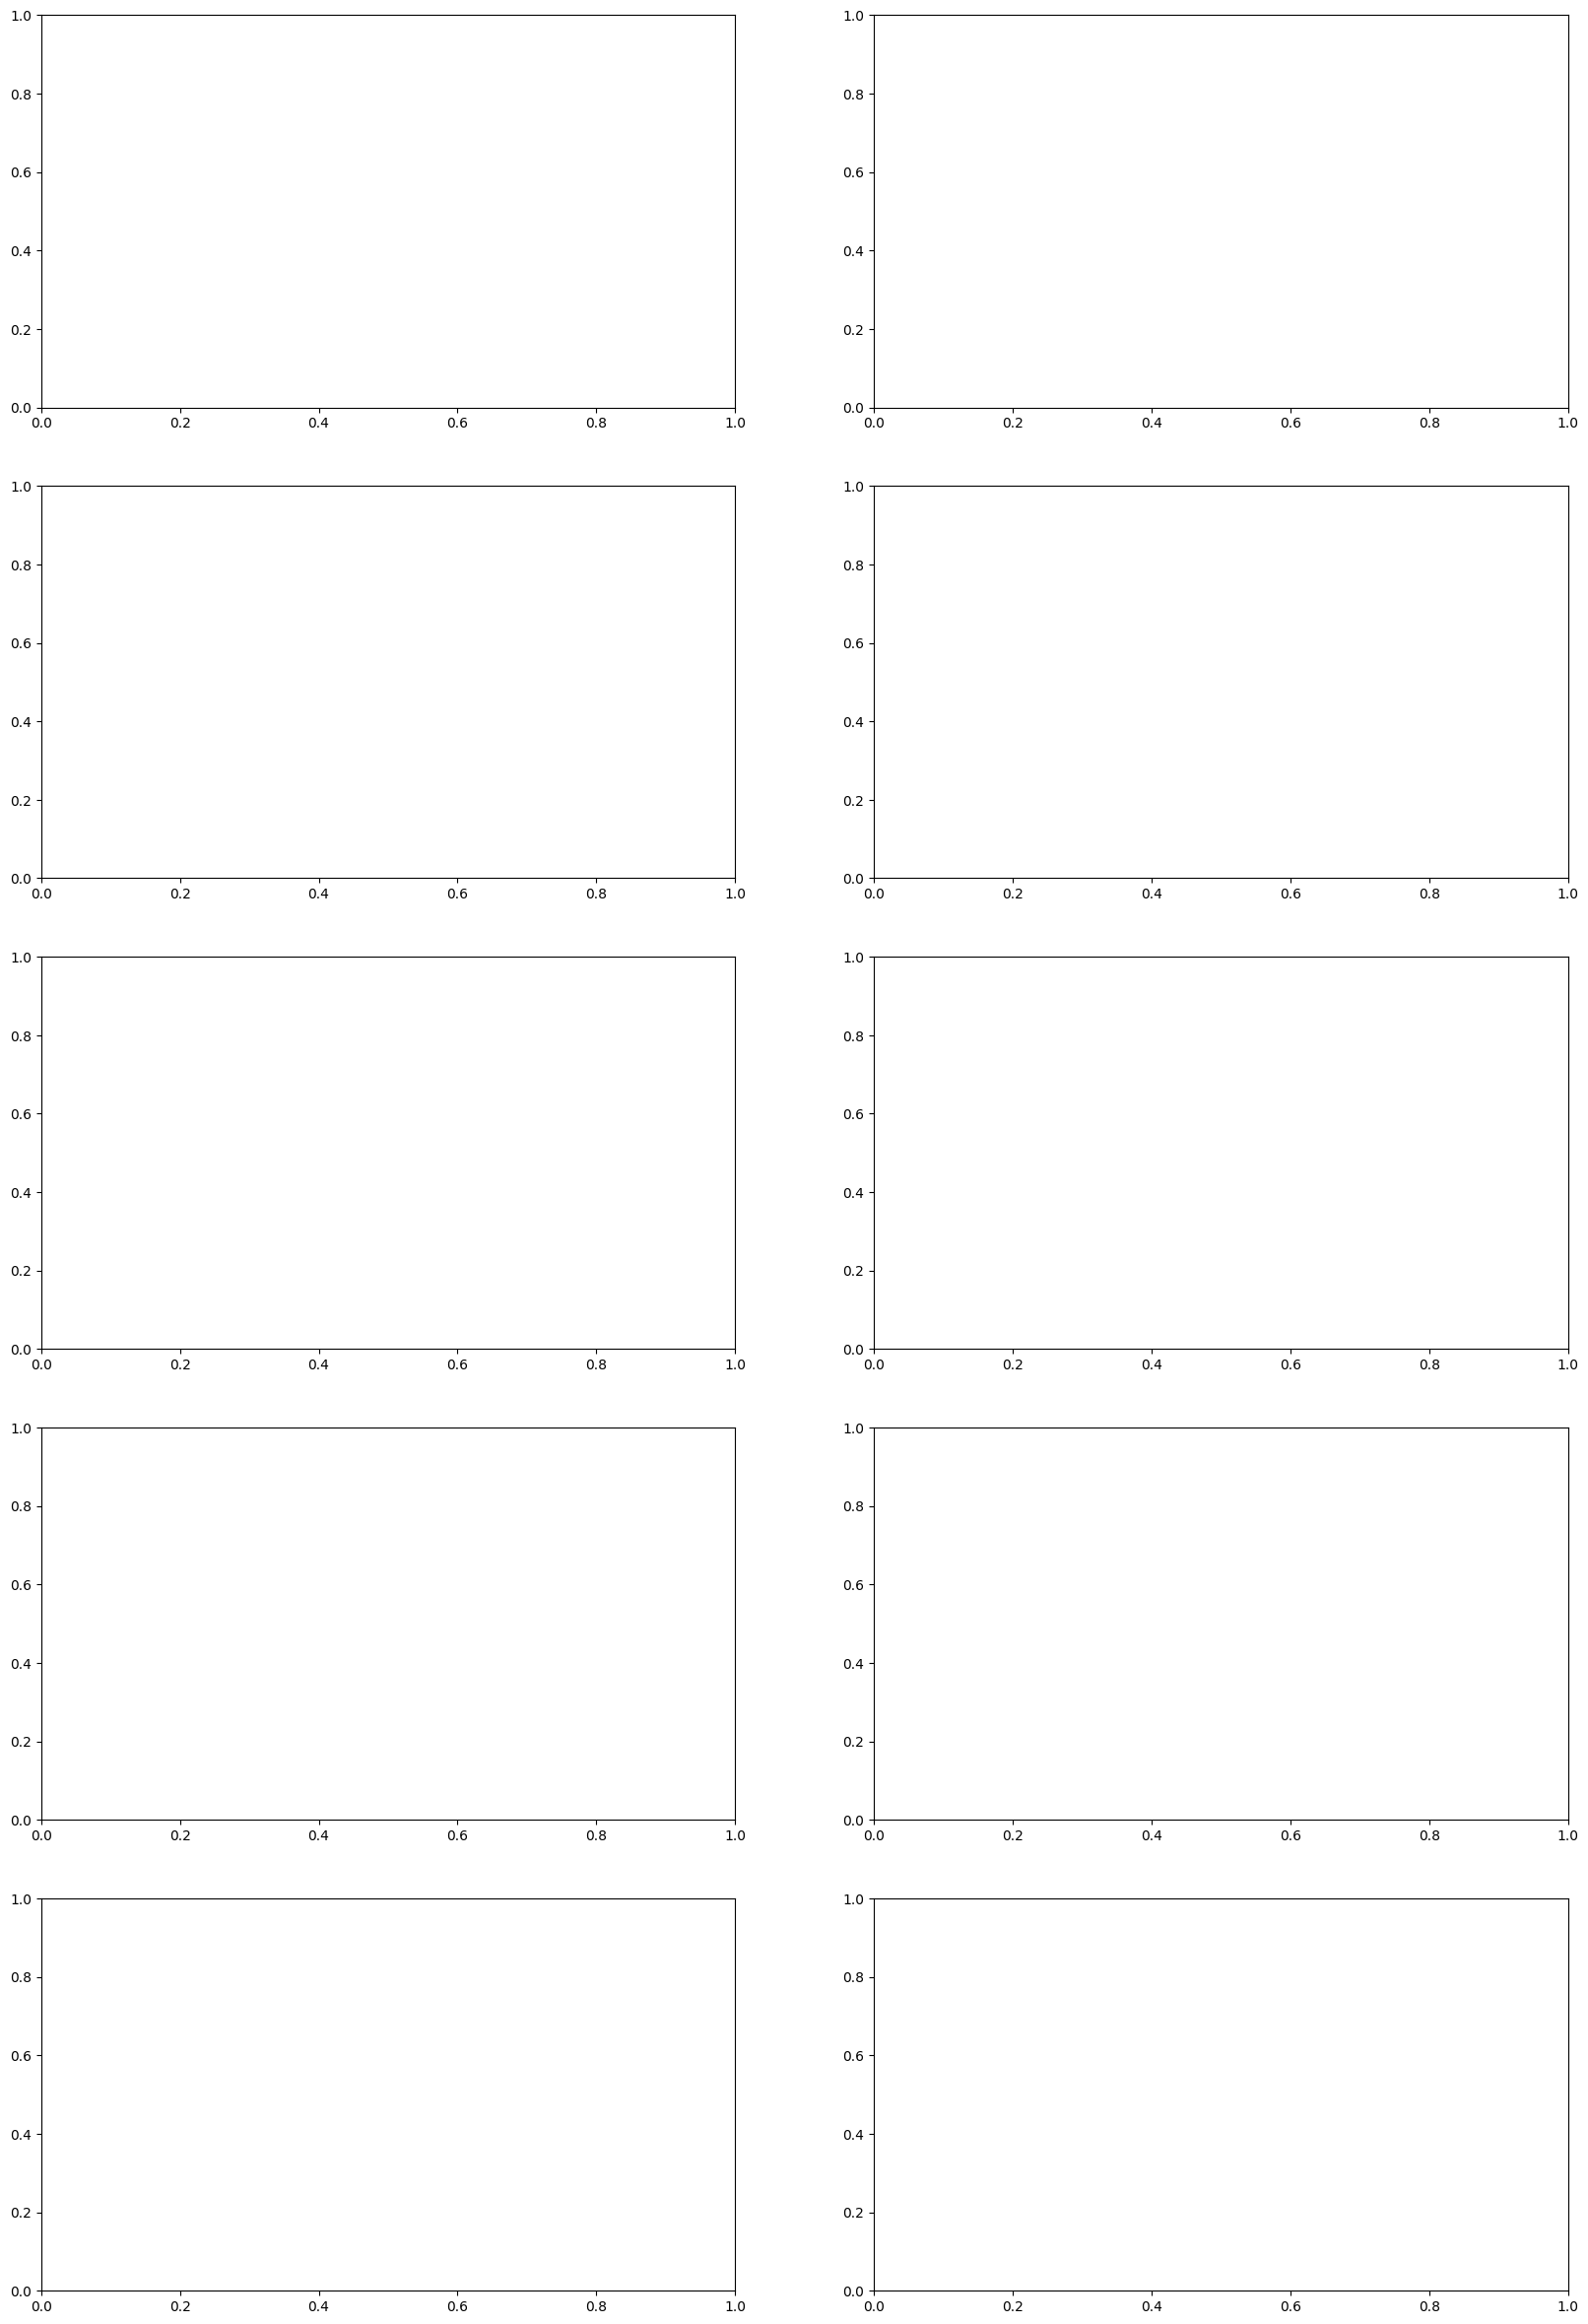

In [7]:
fig, axs = plt.subplots(5, 2, figsize=(20, 30))

for i, neighborhood in enumerate(neigborhoods_to_analize):

    df_neighborhood = df_analize[df_analize.neighborhood == neighborhood]

    axs[i//2, i%2].scatter(df_neighborhood['covered_area'], df_neighborhood['price_value'])
    axs[i//2, i%2].set_title(f'Price value distribution for {neighborhood}')
    axs[i//2, i%2].axhline(df_neighborhood['price_value'].mean(), color='red')


    axs.flat[i].set(xlabel='covered area', ylabel='price value')

plt.show()

NameError: name 'df_analize' is not defined

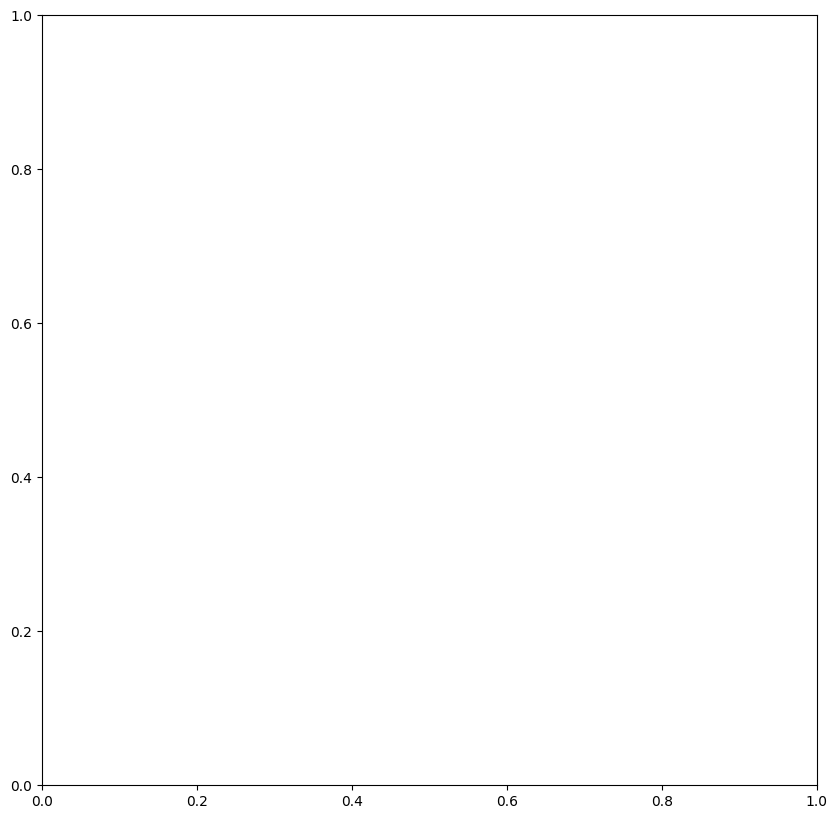

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

df_neighborhoods_mean_price = df_analize.groupby('neighborhood').price_value.mean().sort_values(ascending=False)

ax.barh(df_neighborhoods_mean_price.index, df_neighborhoods_mean_price.values, color='lightblue')


first_color_bound = 80000
second_color_bound = 100000
third_color_bound = 120000

ax.barh(df_neighborhoods_mean_price[df_neighborhoods_mean_price > first_color_bound].index, df_neighborhoods_mean_price[df_neighborhoods_mean_price > first_color_bound].values, color='blue')

ax.barh(df_neighborhoods_mean_price[df_neighborhoods_mean_price > second_color_bound].index, df_neighborhoods_mean_price[df_neighborhoods_mean_price > second_color_bound].values, color='darkblue')

ax.barh(df_neighborhoods_mean_price[df_neighborhoods_mean_price > third_color_bound].index, df_neighborhoods_mean_price[df_neighborhoods_mean_price > third_color_bound].values, color='red')

plt.title('Mean price value for each neighborhood')

plt.show()

We can see that the price of the apartments in the north of Buenos Aires is higher than the price of the rest of the apartments as it is expected.

NameError: name 'df_analize' is not defined

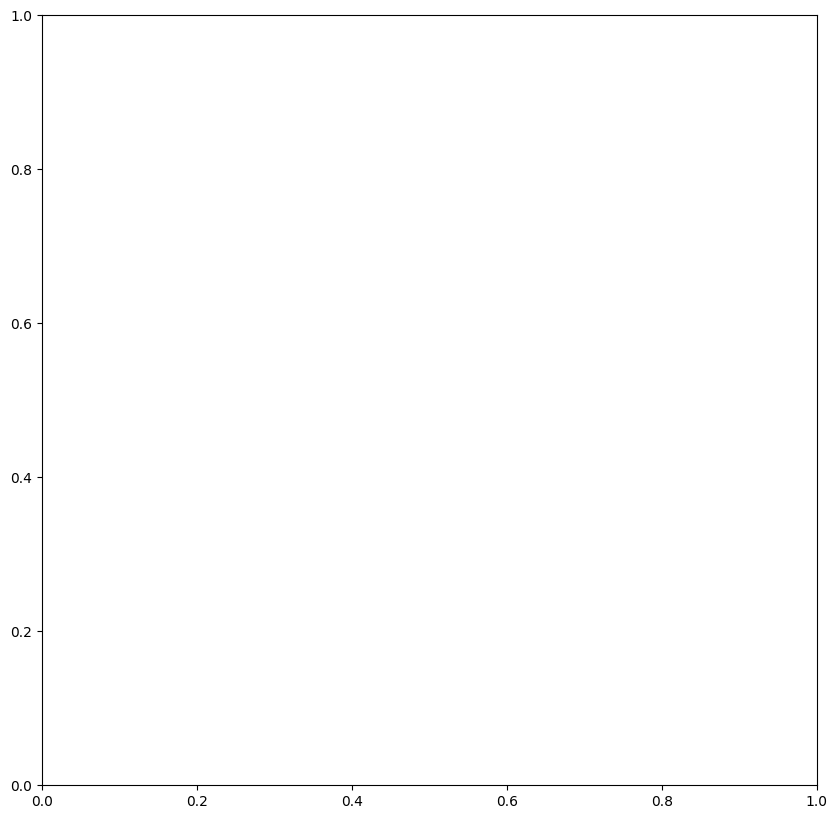

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

df_rooms_mean_price = df_analize.groupby('rooms_0').price_value.mean().sort_values(ascending=False)

ax.bar(df_rooms_mean_price.index, df_rooms_mean_price.values, color='lightblue')


first_color_bound = 80000
second_color_bound = 100000
third_color_bound = 120000

ax.bar(df_rooms_mean_price[df_rooms_mean_price > first_color_bound].index, df_rooms_mean_price[df_rooms_mean_price > first_color_bound].values, color='blue')

ax.bar(df_rooms_mean_price[df_rooms_mean_price > second_color_bound].index, df_rooms_mean_price[df_rooms_mean_price > second_color_bound].values, color='darkblue')

ax.bar(df_rooms_mean_price[df_rooms_mean_price > third_color_bound].index, df_rooms_mean_price[df_rooms_mean_price > third_color_bound].values, color='red')

plt.title('Mean price value in function of rooms')

plt.show()

As we expected, the price of the apartments increases with the rooms quantity.

The decrease of the price in the apartments with 8 rooms maybe is because there are few apartments with 8 rooms.

Let's see the distribution of the price of the apartment in function of parking quantity.

We will assume that the parking quantity of the nan values is 0.

In [ ]:
df_analize.parking_0.fillna(0, inplace=True)

NameError: name 'df_analize' is not defined

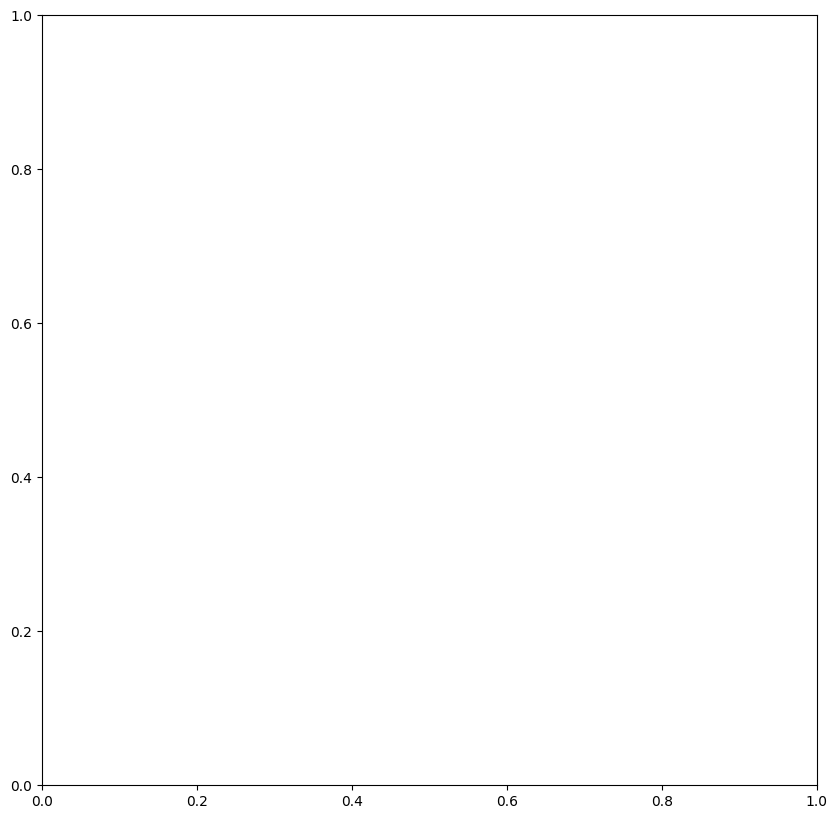

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

df_parking_mean_price = df_analize.groupby('parking_0').price_value.mean().sort_values(ascending=False)

ax.bar(df_parking_mean_price.index, df_parking_mean_price.values, color='blue')

plt.title('Mean price value in function of parking')

plt.show()

The price of the apartments seems to increase linearly with the parking spaces quantity.

# Predictive Analysis

We will try to use a machine learning model to predict the price of an apartment for each neighborhood.

The features that we are going to use will be the total area, covered area, rooms, bathrooms and parking.

Consider that as a proof of concept.

In [ ]:
columns_to_train = ['covered_area', 'total_area', 'rooms_0', 'bathrooms_0', 'parking_0']

In [ ]:
columns = columns_to_train + ['price_value', 'neighborhood', 'city']

In [ ]:
df_train = df_analize[columns].dropna(subset=columns_to_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [ ]:
def model_and_metrics(model, X_test, y_test):
    model_dict = {}
    model_dict['metrics'] = {}

    model_dict['model'] = model
    model_dict['metrics'] = {}
    model_dict['metrics']['RMSE'] = mean_squared_error(y_test, model.predict(X_test), squared=False)
    model_dict['metrics']['MAE'] = mean_absolute_error(y_test, model.predict(X_test))

    return model_dict

In [ ]:
models = {}

scaler = StandardScaler()
y_scaler = StandardScaler()

scaler.fit(df_train[columns_to_train].values)

y_scaler.fit(df_train.price_value.values.reshape(-1, 1))

data_test_by_neighborhood = {}


for neighborhood in neigborhoods_to_analize:

    models[neighborhood] = {}

    df_neighborhood = df_train[df_train.neighborhood == neighborhood]

    X = df_neighborhood[columns_to_train].values
    y = df_neighborhood.price_value.values

    X = scaler.transform(X)
    y = y_scaler.transform(y.reshape(-1, 1)).ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    lr = LinearRegression()

    lr.fit(X_train, y_train)

    models[neighborhood]['Linear Regression'] = model_and_metrics(lr, X_test, y_test)

    rf = RandomForestRegressor(n_estimators=1000, random_state=0, max_depth=4)

    rf.fit(X_train, y_train)

    rf_dict = model_and_metrics(rf, X_test, y_test)

    models[neighborhood]['Random Forest'] = rf_dict

    mlp = MLPRegressor(random_state=1, max_iter=5000, hidden_layer_sizes=(10, 10), early_stopping=True, validation_fraction=0.1, learning_rate_init=0.001, activation='relu')

    mlp.fit(X_train, y_train)

    mlp_dict = model_and_metrics(mlp, X_test, y_test)

    models[neighborhood]['MLP'] = mlp_dict

    data_test_by_neighborhood[neighborhood] = {
        'X_test': X_test,
        'y_test': y_test
    }


In [ ]:
df_metrics = pd.DataFrame(columns=['neighborhood', 'model', 'RMSE', 'MAE'])

for neighborhood in models.keys():
    for model in models[neighborhood].keys():

        df_metrics = df_metrics.append({'neighborhood': neighborhood, 'model': model, 'RMSE': models[neighborhood][model]['metrics']['RMSE'], 'MAE': models[neighborhood][model]['metrics']['MAE']}, ignore_index=True)

In [ ]:
df_metrics = df_metrics.set_index(['neighborhood', 'model'])

# Metrics

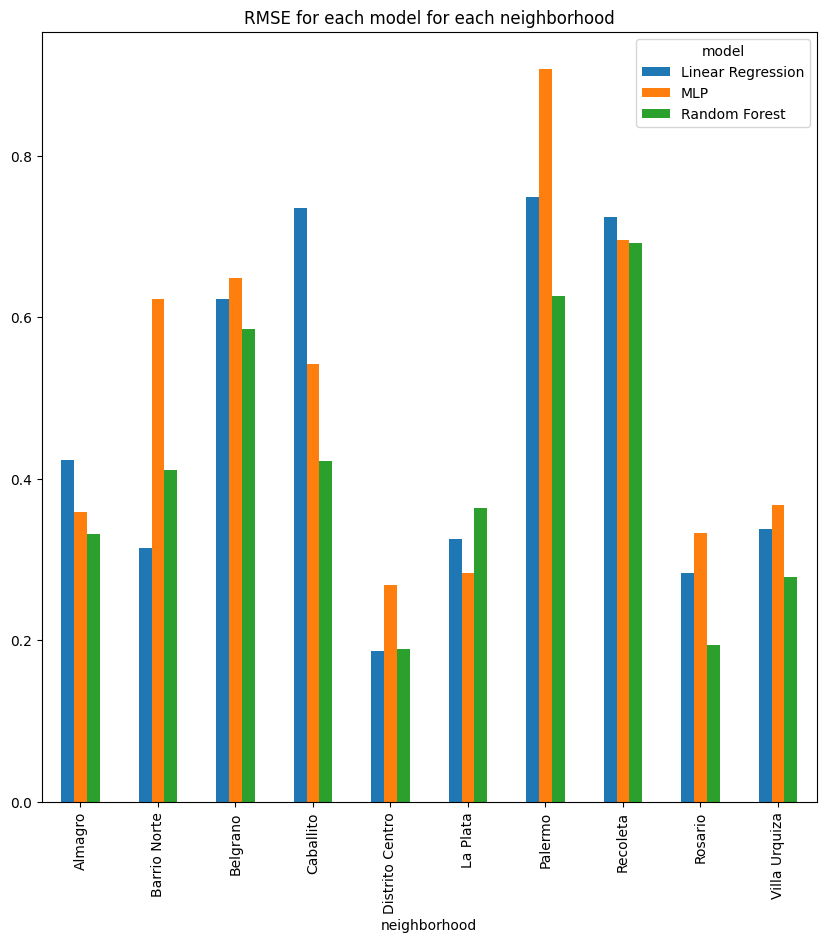

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

df_metrics.loc[:, 'RMSE'].unstack().plot.bar(ax=ax)

plt.title('RMSE for each model for each neighborhood')

plt.show()


In [ ]:
def plot_predictions(sample_apartment, model_name, X_scaler, y_scaler, neighborhoods):

    fig, ax = plt.subplots(figsize=(10, 10))

    for neighborhood in neighborhoods:

        predictions = models[neighborhood][model_name]['model'].predict(X_scaler.transform(sample_apartment[columns_to_train].values))

        predictions = y_scaler.inverse_transform(predictions.reshape(-1, 1)).ravel()

        ax.plot(sample_apartment.covered_area, predictions, label=neighborhood)

    ax.legend()

    ax.set_title(f'{model_name} predictions for different neighborhoods')

    ax.set_xlabel('covered area')

    ax.set_ylabel('price value')

    plt.show()

In [ ]:
sample_apartment = pd.DataFrame({
    'covered_area': np.arange(0, 200, 1),
    'total_area': np.arange(0, 200, 1),
    'rooms_0': 2,
    'bathrooms_0': 1,
    'parking_0': 0
})

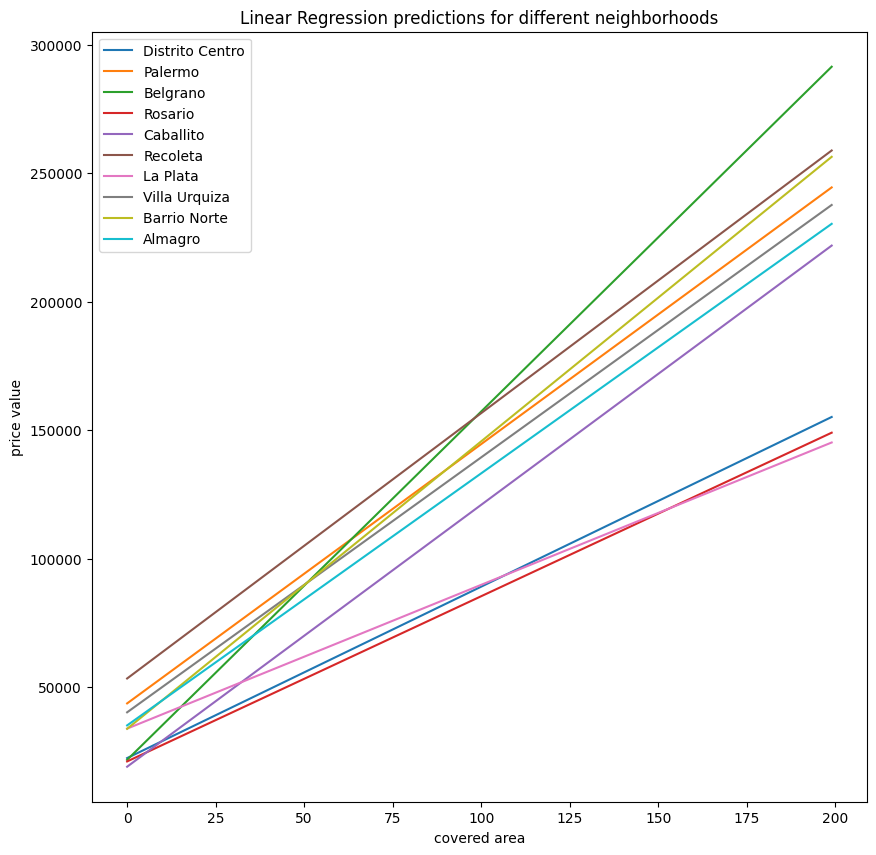

In [ ]:
plot_predictions(sample_apartment, 'Linear Regression', scaler, y_scaler, neigborhoods_to_analize)

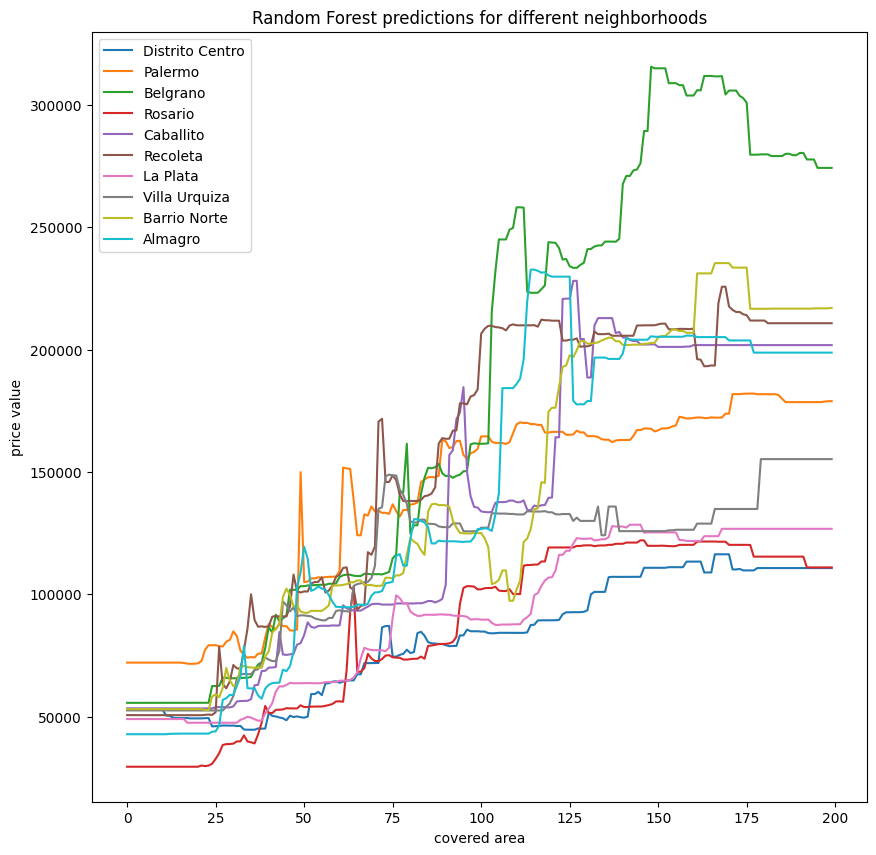

In [ ]:
plot_predictions(sample_apartment, 'Random Forest', scaler, y_scaler, neigborhoods_to_analize)

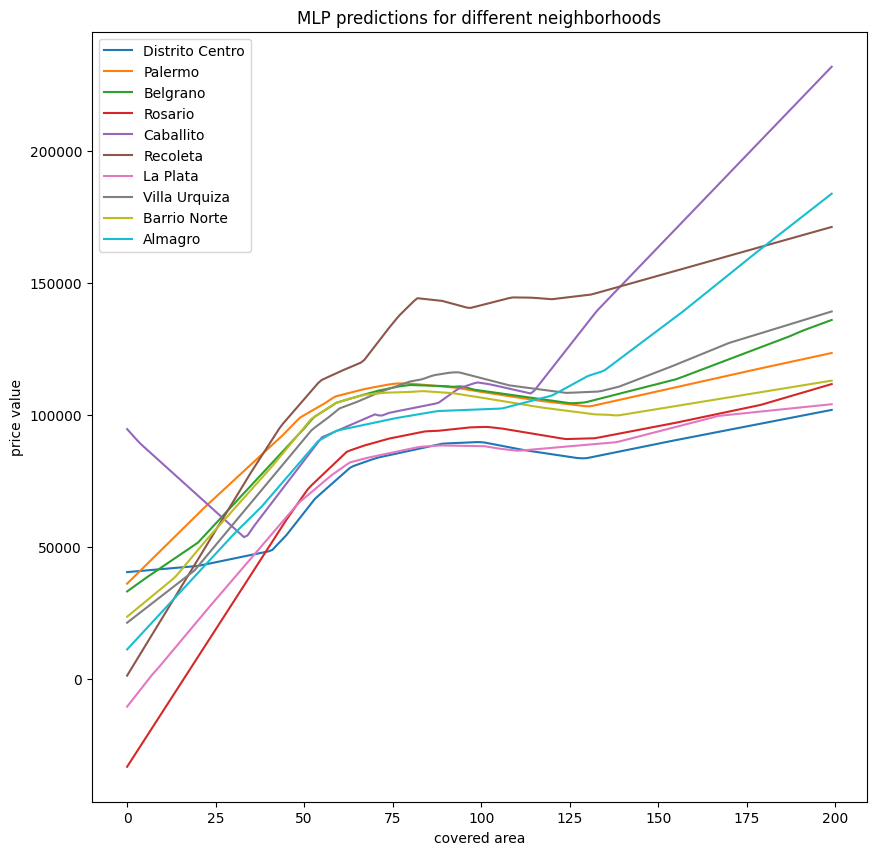

In [ ]:
plot_predictions(sample_apartment, 'MLP', scaler, y_scaler, neigborhoods_to_analize)

We could see how are the predictions for one neighborhood for each model.

The predictions are made using all the features that we mentioned before but we will see theses predictions in a covered area vs price plot.

In [12]:

neighborhood = 'Palermo'

X_test, y_test = data_test_by_neighborhood[neighborhood]['X_test'], data_test_by_neighborhood[neighborhood]['y_test']

# sort by first column of X_test both X_test and y_test
X_test, y_test = zip(*sorted(zip(X_test, y_test), key=lambda x: x[0][0]))

X_test, y_test = np.array(X_test), np.array(y_test)

mlp_predictions = models[neighborhood]['MLP']['model'].predict(X_test)

mlp_predictions = y_scaler.inverse_transform(mlp_predictions.reshape(-1, 1)).ravel()

rf_predictions = models[neighborhood]['Random Forest']['model'].predict(X_test)

rf_predictions = y_scaler.inverse_transform(rf_predictions.reshape(-1, 1)).ravel()

lr_predictions = models[neighborhood]['Linear Regression']['model'].predict(X_test)

lr_predictions = y_scaler.inverse_transform(lr_predictions.reshape(-1, 1)).ravel()

y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()


fig, ax = plt.subplots(figsize=(20, 20), nrows=3)

def plot_in_axis(ax, x, y, predictions, title):

    ax.scatter(x[:, 0], y, label='real values')

    ax.plot(x[:, 0], predictions, label='predictions', color = 'red')

    ax.set_title(title)

    ax.set_xlabel('covered area')

    ax.set_ylabel('price value')

    ax.legend()


plot_in_axis(ax[0], X_test, y_test, mlp_predictions, 'MLP')

plot_in_axis(ax[1], X_test, y_test, rf_predictions, 'Random Forest')

plot_in_axis(ax[2], X_test, y_test, lr_predictions, 'Linear Regression')

plt.show()

NameError: name 'data_test_by_neighborhood' is not defined

All the predictors are similar.

# Conclusion

We have seen how is the data and what are the features.

We saw that the north of Buenos Aires is the most expensive zone, and the price of the apartments increases with the rooms quantity, the area and the parking spaces quantity as it is expected.

We saw the correlation between the features and the price of the apartment.

This could be useful to monitor the market and to know if the price of the apartments is increasing or decreasing.

Then we try to predict the price of an apartment for each neighborhood using machine learning models.

This could be useful for people that want to rent an apartment in Argentina and want to know a reasonable price of an apartment in a specific area.

This analysis could be doing for buying or selling apartments too.


## Idea

Using extra information about the neighborhoods, (for example, the income, the life quality, the facilities, etc.) you can be do an estate scorer that rates the apartments.

This could help people to choose the best apartment for them.